In [1]:
import typing
import numpy as np
import pandas as pd
import interpretable as inter
import interpretable_linear_data as interData
import tqdm.auto as tqdm
import matplotlib as mpl
import matplotlib.pyplot as plt 
import tensorflow as tf
from tensorflow.python.eager import context

tf.config.threading.set_inter_op_parallelism_threads(5)
_ = tf.Variable([1])

import DeepLearningInterpretable as DLI

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.constraints import NonNeg 

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing

from scipy.optimize import curve_fit
from pandas import Grouper as tg

scaler = StandardScaler()

In [3]:
def plot_kernels(kernels, ax):
    for kernel in kernels: 
        ax.plot(kernels[kernel][1:], label = 'kernel approx with kernel:'+str(kernel))
        ax.set_title('regressed kernel ')
        ax.set_xlabel('t')
        ax.set_ylabel('Price ($)')
        ax.set_xlim((1,500))
        ax.legend()
        
def plot_loss(ax, history):
    ax.plot(history.history['loss'])
    ax.plot(history.history['val_loss'])
    ax.set_title('model loss')
    ax.set_ylabel('loss')
    ax.set_xlabel('epoch')
    ax.legend(['train', 'test'], loc='upper right')


In [4]:
def fNN(row):
    if row['sign'] > 0:
        return row['ask_size']
    else:
        return row['bid_size']
def fWN(row):
    if row['sign'] > 0:
        return row['ask_size_normalized']
    else:
        return row['bid_size_normalized']

$\underline{\text{Data Loading:}}$

In [5]:
# load clean data
%store -r dfSPMINI
%store -r dfUST
#dfSPMINI = pd.read_csv('dfSPMINI.csv')
#dfSPMINI = pd.read_csv('dfUST.csv')

dfSPMINI = dfSPMINI.head(3000000)

dfSPMINI['sign'] = dfSPMINI['qty_signed'].apply(lambda x: np.sign(x))
dfUST['sign'] = dfUST['qty_signed'].apply(lambda x: np.sign(x))

#dfSPMINI['best_opposed_quantity_NN'] = dfSPMINI.apply(fNN, axis = 1) # we select the best opposed qtys without normalization
#dfUST['best_opposed_quantity_NN'] = dfUST.apply(fNN, axis = 1) # we select the best opposed qtys without normalization

dfSPMINI['best_opposed_quantity_WN'] = dfSPMINI.apply(fWN, axis = 1) # we select the best opposed qtys with normalization
dfUST['best_opposed_quantity_WN'] = dfUST.apply(fWN, axis = 1) # we select the best opposed qtys with normalization

#  q_t/V_t:
#dfSPMINI['quotient_trades_best_opposed_NN'] = dfSPMINI['qty'].div(dfSPMINI['best_opposed_quantity_NN']) # quotient with non-normalized data
#dfUST['quotient_trades_best_opposed_NN'] = dfUST['qty'].div(dfUST['best_opposed_quantity_NN']) # quotient with non-normalized data

dfSPMINI['quotient_trades_best_opposed_MN'] = dfSPMINI['qty_signed_normalized']/(dfSPMINI['best_opposed_quantity_WN'].mean()) # quotient with normalized data and we use the mean as denominator
dfUST['quotient_trades_best_opposed_MN'] = dfUST['qty_signed_normalized']/(dfUST['best_opposed_quantity_WN'].mean()) # quotient with normalized data and we use the mean as denominator

dfSPMINI['quotient_trades_best_opposed_WN'] = dfSPMINI['qty_signed_normalized'].div(dfSPMINI['best_opposed_quantity_WN']) # quotient with normalized data, q_t/V_t
dfUST['quotient_trades_best_opposed_WN'] = dfUST['qty_signed_normalized'].div(dfUST['best_opposed_quantity_WN']) # quotient with normalized data


/home/gpalmari/conda/envs/gpu_env/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
/home/gpalmari/conda/envs/gpu_env/lib/python3.6/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
/home/gpalmari/conda/envs/gpu_env/lib/python3.6/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.

In [6]:
# we store the desired data

#SPMINI
mid_SPMINI = dfSPMINI['mid'].copy()

returns_SPMINI = dfSPMINI['returns'].copy()
returns_normalized_SPMINI = dfSPMINI['returns_normalized'].copy()

qty_signed_normalized_SPMINI = dfSPMINI['qty_signed_normalized'].copy()
epsilons_SPMINI = qty_signed_normalized_SPMINI.apply(lambda x: np.sign(x)).copy()
qty_signed_SPMINI = dfSPMINI['qty'].multiply(epsilons_SPMINI)

quotient_normalized_SPMINI = dfSPMINI['quotient_trades_best_opposed_WN'].copy()
quotient_mean_normalized_SPMINI = dfSPMINI['quotient_trades_best_opposed_MN'].copy()

#UST
mid_UST = dfUST['mid'].copy()

returns_UST = dfUST['returns'].copy()
returns_normalized_UST = dfUST['returns_normalized'].copy()

qty_signed_normalized_UST = dfUST['qty_signed_normalized'].copy()
epsilons_UST = qty_signed_normalized_UST.apply(lambda x: np.sign(x)).copy()
qty_signed_UST = dfUST['qty'].multiply(epsilons_UST)

quotient_normalized_UST = dfUST['quotient_trades_best_opposed_WN'].copy()
quotient_mean_normalized_UST = dfUST['quotient_trades_best_opposed_MN'].copy()

# lengths
N_SPMINI = len(mid_SPMINI)
N_UST = len(mid_UST)

L = 500
Y_SPMINI = returns_normalized_SPMINI.values[L:]
Y_UST = returns_normalized_UST.values[L:]

$\underline{\text{Learning quantities:}}$

In [7]:
max_lag = 1000
L = 500

# we define the regression matrix for each method of learning

# SPMINI
A_SPMINI = inter.regression_matrix(qty_signed_SPMINI.values, L)
A_SPMINI_two_features1 = inter.regression_matrix(quotient_normalized_SPMINI, L)
A_SPMINI_two_features2 = inter.regression_matrix(quotient_mean_normalized_SPMINI, L)



#UST
A_UST = inter.regression_matrix(qty_signed_UST.values, L)
A_UST_two_features1 = inter.regression_matrix(quotient_normalized_UST, L)
A_UST_two_features2 = inter.regression_matrix(quotient_mean_normalized_UST, L)



In [8]:
#optimizer = tf.keras.optimizers.SGD(learning_rate = 0.1)
#optimizer = tf.optimizers.Adam(learning_rate = 0.0001)
#optimizer = tf.keras.optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.001)

optimizer_SPMINI = tf.keras.optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.001)
optimizer_UST = tf.keras.optimizers.Adam(lr = 0.01, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-08, decay = 0.001)
batch_size_SPMINI = int(N_SPMINI/10000)
batch_size_UST = int(N_UST/10000)
callback = tf.keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)

$\underline{\text{Model with bid/ask volume and trades:}}$

In [9]:
matrix_concat_SPMINI = np.concatenate((A_SPMINI_two_features1,A_SPMINI_two_features2), axis = 1)
matrix_concat_UST = np.concatenate((A_UST_two_features1,A_UST_two_features2), axis = 1)

In [10]:
model_two_features_SPMINI, history_two_features_SPMINI = DLI.modelDoublePowerLaw(matrix_concat_SPMINI, 
                                                                   Y_SPMINI, optimizer_SPMINI, batch_size_SPMINI, 
                                                                   epochs = 200)

model_two_features_UST, history_two_features_UST = DLI.modelDoublePowerLaw(matrix_concat_UST, 
                                                                   Y_UST, optimizer_SPMINI, batch_size_UST, 
                                                                   epochs = 200)

Epoch 1/200
6999/6999 [==============================] - 38s 5ms/step - loss: 1.8170 - val_loss: 0.7520
Epoch 2/200
6999/6999 [==============================] - 31s 4ms/step - loss: 0.9423 - val_loss: 0.7466
Epoch 3/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.9360 - val_loss: 0.7432
Epoch 4/200
6999/6999 [==============================] - 31s 4ms/step - loss: 0.9337 - val_loss: 0.7422
Epoch 5/200
6999/6999 [==============================] - 31s 4ms/step - loss: 0.9314 - val_loss: 0.7409
Epoch 6/200
6999/6999 [==============================] - 31s 4ms/step - loss: 0.9303 - val_loss: 0.7405
Epoch 7/200
6999/6999 [==============================] - 31s 4ms/step - loss: 0.9298 - val_loss: 0.7399
Epoch 8/200
6999/6999 [==============================] - 32s 5ms/step - loss: 0.9292 - val_loss: 0.7391
Epoch 9/200
6999/6999 [==============================] - 32s 5ms/step - loss: 0.9288 - val_loss: 0.7391
Epoch 10/200
6999/6999 [==============================] - 32s 5m

6999/6999 [==============================] - 33s 5ms/step - loss: 0.9262 - val_loss: 0.7374
Epoch 80/200
6999/6999 [==============================] - 32s 5ms/step - loss: 0.9262 - val_loss: 0.7374
Epoch 81/200
6999/6999 [==============================] - 32s 5ms/step - loss: 0.9262 - val_loss: 0.7373
Epoch 82/200
6999/6999 [==============================] - 32s 5ms/step - loss: 0.9262 - val_loss: 0.7374
Epoch 83/200
6999/6999 [==============================] - 31s 4ms/step - loss: 0.9265 - val_loss: 0.7374
Epoch 84/200
6999/6999 [==============================] - 31s 4ms/step - loss: 0.9265 - val_loss: 0.7373
Epoch 85/200
6999/6999 [==============================] - 31s 4ms/step - loss: 0.9263 - val_loss: 0.7374
Epoch 86/200
6999/6999 [==============================] - 30s 4ms/step - loss: 0.9262 - val_loss: 0.7373
Epoch 87/200
6999/6999 [==============================] - 30s 4ms/step - loss: 0.9263 - val_loss: 0.7374
Epoch 88/200
6999/6999 [==============================] - 30s 4ms/st

6999/6999 [==============================] - 33s 5ms/step - loss: 0.9258 - val_loss: 0.7373
Epoch 157/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.9256 - val_loss: 0.7373
Epoch 158/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.9258 - val_loss: 0.7372
Epoch 159/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.9265 - val_loss: 0.7373
Epoch 160/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.9263 - val_loss: 0.7373
Epoch 161/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.9261 - val_loss: 0.7373
Epoch 162/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.9260 - val_loss: 0.7373
Epoch 163/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.9259 - val_loss: 0.7373
Epoch 164/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.9263 - val_loss: 0.7373
Epoch 165/200
6999/6999 [==============================] - 3

6997/6997 [==============================] - 17s 2ms/step - loss: 1.1463 - val_loss: 0.9685
Epoch 27/200
6997/6997 [==============================] - 18s 3ms/step - loss: 1.1149 - val_loss: 0.9519
Epoch 28/200
6997/6997 [==============================] - 18s 3ms/step - loss: 1.0842 - val_loss: 0.9380
Epoch 29/200
6997/6997 [==============================] - 19s 3ms/step - loss: 1.0592 - val_loss: 0.9266
Epoch 30/200
6997/6997 [==============================] - 19s 3ms/step - loss: 1.0361 - val_loss: 0.9172
Epoch 31/200
6997/6997 [==============================] - 18s 3ms/step - loss: 1.0171 - val_loss: 0.9093
Epoch 32/200
6997/6997 [==============================] - 17s 2ms/step - loss: 1.0020 - val_loss: 0.9027
Epoch 33/200
6997/6997 [==============================] - 17s 2ms/step - loss: 0.9875 - val_loss: 0.8972
Epoch 34/200
6997/6997 [==============================] - 17s 2ms/step - loss: 0.9760 - val_loss: 0.8926
Epoch 35/200
6997/6997 [==============================] - 17s 2ms/st

6997/6997 [==============================] - 19s 3ms/step - loss: 0.8952 - val_loss: 0.8654
Epoch 105/200
6997/6997 [==============================] - 17s 2ms/step - loss: 0.8951 - val_loss: 0.8654
Epoch 106/200
6997/6997 [==============================] - 19s 3ms/step - loss: 0.8957 - val_loss: 0.8654
Epoch 107/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.8964 - val_loss: 0.8655
Epoch 108/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.8945 - val_loss: 0.8655
Epoch 109/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.8955 - val_loss: 0.8654
Epoch 110/200
6997/6997 [==============================] - 19s 3ms/step - loss: 0.8949 - val_loss: 0.8654
Epoch 111/200
6997/6997 [==============================] - 19s 3ms/step - loss: 0.8954 - val_loss: 0.8654
Epoch 112/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.8953 - val_loss: 0.8654
Epoch 113/200
6997/6997 [==============================] - 1

6997/6997 [==============================] - 17s 2ms/step - loss: 0.8951 - val_loss: 0.8655
Epoch 182/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.8955 - val_loss: 0.8655
Epoch 183/200
6997/6997 [==============================] - 17s 2ms/step - loss: 0.8957 - val_loss: 0.8655
Epoch 184/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.8963 - val_loss: 0.8655
Epoch 185/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.8959 - val_loss: 0.8655
Epoch 186/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.8949 - val_loss: 0.8655
Epoch 187/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.8957 - val_loss: 0.8655
Epoch 188/200
6997/6997 [==============================] - 19s 3ms/step - loss: 0.8955 - val_loss: 0.8655
Epoch 189/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.8958 - val_loss: 0.8655
Epoch 190/200
6997/6997 [==============================] - 1

In [35]:
GNNDPL_approx1_two_features_SPMINI = pd.concat((pd.Series([0]), pd.Series(model_two_features_SPMINI.layers[2].kernel[:L+1].numpy().cumsum())))
GNNDPL_approx2_two_features_SPMINI = pd.concat((pd.Series([0]), pd.Series(model_two_features_SPMINI.layers[2].kernel[L+1:].numpy().cumsum())))

GNNDPL_approx1_two_features_UST = pd.concat((pd.Series([0]), pd.Series(model_two_features_UST.layers[2].kernel[:L+1].numpy().cumsum())))
GNNDPL_approx2_two_features_UST = pd.concat((pd.Series([0]), pd.Series(model_two_features_UST.layers[2].kernel[L+1:].numpy().cumsum())))

%store GNNDPL_approx1_two_features_SPMINI
%store GNNDPL_approx2_two_features_SPMINI

%store GNNDPL_approx1_two_features_UST
%store GNNDPL_approx2_two_features_UST

alphaGNNDPL_approx1_two_features_SPMINI = model_two_features_SPMINI.layers[0].kernel.numpy()[0]
alphaGNNDPL_approx2_two_features_SPMINI = model_two_features_SPMINI.layers[0].kernel.numpy()[1]

alphaGNNDPL_approx1_two_features_UST = model_two_features_UST.layers[0].kernel.numpy()[0]
alphaGNNDPL_approx2_two_features_UST = model_two_features_UST.layers[0].kernel.numpy()[1]

%store alphaGNNDPL_approx1_two_features_SPMINI
%store alphaGNNDPL_approx2_two_features_SPMINI

%store alphaGNNDPL_approx1_two_features_UST
%store alphaGNNDPL_approx2_two_features_UST

Stored 'GNNDPL_approx1_two_features_SPMINI' (Series)
Stored 'GNNDPL_approx2_two_features_SPMINI' (Series)
Stored 'GNNDPL_approx1_two_features_UST' (Series)
Stored 'GNNDPL_approx2_two_features_UST' (Series)
Stored 'alphaGNNDPL_approx1_two_features_SPMINI' (float32)
Stored 'alphaGNNDPL_approx2_two_features_SPMINI' (float32)
Stored 'alphaGNNDPL_approx1_two_features_UST' (float32)
Stored 'alphaGNNDPL_approx2_two_features_UST' (float32)


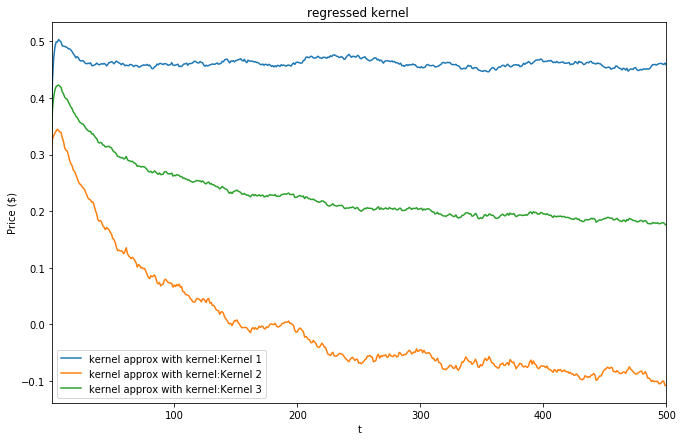

In [12]:
kernels = {'Kernel 1': GNNDPL_approx1_two_features_UST, 'Kernel 2': GNNDPL_approx2_two_features_UST, 'Kernel 3': (GNNDPL_approx1_two_features_UST+GNNDPL_approx2_two_features_UST)/2}
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_kernels(kernels, ax)

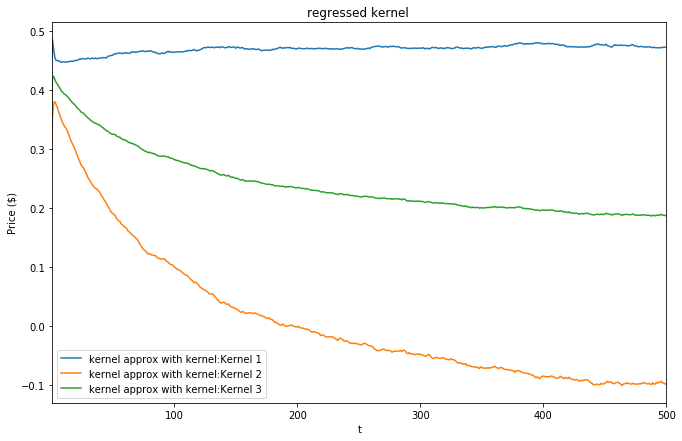

In [13]:
kernels = {'Kernel 1': GNNDPL_approx1_two_features_SPMINI, 'Kernel 2': GNNDPL_approx2_two_features_SPMINI, 'Kernel 3': (GNNDPL_approx1_two_features_SPMINI+GNNDPL_approx2_two_features_SPMINI)/2}
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_kernels(kernels, ax)

In [32]:
yapprox_UST = model_two_features_UST.predict(matrix_concat_UST)
r2_score(Y_UST, yapprox_UST)

0.12208473912129891

In [34]:
yapprox_SPMINI = model_two_features_SPMINI.predict(matrix_concat_SPMINI)
r2_score(Y_SPMINI, yapprox_SPMINI)

0.2199758623338729

In [16]:
returnsapproxGNNTFPL_SPMINI = model_two_features_SPMINI.predict(matrix_concat_SPMINI)
returnsapproxGNNTFPL_UST = model_two_features_UST.predict(matrix_concat_UST)
% store returnsapproxGNNTFPL_SPMINI
% store returnsapproxGNNTFPL_UST

R2_PowerModelGNNTFPL_SPMINI = r2_score(Y_SPMINI, returnsapproxGNNTFPL_SPMINI)
print('R^2 train (returns): %.3f' % R2_PowerModelGNNTFPL_SPMINI )

R2_PowerModelGNNTFPL_UST = r2_score(Y_UST, returnsapproxGNNTFPL_UST)
print('R^2 train (returns): %.3f' % R2_PowerModelGNNTFPL_UST )

% store R2_PowerModelGNNTFPL_SPMINI
% store R2_PowerModelGNNTFPL_UST

Stored 'returnsapproxGNNTFPL_SPMINI' (ndarray)
Stored 'returnsapproxGNNTFPL_UST' (ndarray)
R^2 train (returns): 0.220
R^2 train (returns): 0.122
Stored 'R2_PowerModelGNNTFPL_SPMINI' (float64)
Stored 'R2_PowerModelGNNTFPL_UST' (float64)


In [ ]:
synthetic_variogram_GNNTFPL_approx_SPMINI = inter.variogram2(returnsapproxGNNTFPL_SPMINI.cumsum())
synthetic_variogram_GNNTFPL_approx_UST = inter.variogram2(returnsapproxGNNTFPL_UST.cumsum())
% store synthetic_variogram_GNNTFPL_approx_SPMINI
% store synthetic_variogram_GNNTFPL_approx_UST

plt.plot(synthetic_variogram_GNNTFPL_approx_SPMINI)
plt.plot(synthetic_variogram_GNNTFPL_approx_UST)

$\underline{\text{Model with bid/ask volume:}}$

In [ ]:
A_SPMINI_volume = inter.regression_matrix(dfSPMINI['best_opposed_quantity_WN'], L)
A_UST_volume = inter.regression_matrix(dfUST['best_opposed_quantity_WN'], L)

In [ ]:
model_with_volume_SPMINI, history_with_volume_SPMINI = DLI.modelPowerLaw(A_SPMINI_volume, 
                                                                   Y_SPMINI, optimizer_SPMINI, batch_size_SPMINI, 
                                                                   epochs = 100)

model_with_volume_UST, history_with_volume_UST = DLI.modelPowerLaw(A_UST_volume, 
                                                                   Y_UST, optimizer_UST, batch_size_UST, 
                                                                   epochs = 100)

In [ ]:
GNNPL_approx_with_volume_SPMINI = pd.concat((pd.Series([0]), pd.Series(model_with_volume_SPMINI.layers[1].kernel.numpy().cumsum())))
GNNPL_approx_with_volume_UST = pd.concat((pd.Series([0]), pd.Series(model_with_volume_UST.layers[1].kernel.numpy().cumsum())))

In [ ]:
kernels = {'Kernel': GNNPL_approx_with_volume_SPMINI}
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_kernels(kernels, ax)

In [ ]:
kernels = {'Kernel': GNNPL_approx_with_volume_UST}
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_kernels(kernels, ax)

In [ ]:
yapprox_SPMINI = model_with_volume_SPMINI.predict(A_SPMINI_volume)
r2_score(Y_SPMINI, yapprox_SPMINI)

In [ ]:
yapprox_UST = model_with_volume_UST.predict(A_UST_volume)
r2_score(Y_UST, yapprox_UST)

$\underline{\text{Two baskets Model with bid/ask volume and trades:}}$

In [18]:
max_lag = 1000
L = 500
matrix_volume_basket1_SPMINI, matrix_volume_basket2_SPMINI = inter.regression_matrix_two_baskets(dfSPMINI, L) 
matrix_volume_basket1_UST, matrix_volume_basket2_UST = inter.regression_matrix_two_baskets(dfUST, L)


In [19]:
matrix_two_baskets_SPMINI = np.concatenate((matrix_volume_basket1_SPMINI, matrix_volume_basket2_SPMINI), axis = 1)
model_with_two_baskets_SPMINI, history_with_two_baskets_SPMINI = DLI.modelDoublePowerLaw(matrix_two_baskets_SPMINI, 
                                                                   Y_SPMINI, optimizer_SPMINI, batch_size_SPMINI, 
                                                                   epochs = 100)

Epoch 1/100
6998/6998 [==============================] - 33s 5ms/step - loss: 10.1736 - val_loss: 6.8984
Epoch 2/100
6998/6998 [==============================] - 25s 4ms/step - loss: 8.9450 - val_loss: 6.0699
Epoch 3/100
6998/6998 [==============================] - 25s 4ms/step - loss: 7.9470 - val_loss: 5.3722
Epoch 4/100
6998/6998 [==============================] - 26s 4ms/step - loss: 7.0539 - val_loss: 4.7518
Epoch 5/100
6998/6998 [==============================] - 25s 4ms/step - loss: 6.2444 - val_loss: 4.2048
Epoch 6/100
6998/6998 [==============================] - 25s 4ms/step - loss: 5.5429 - val_loss: 3.7242
Epoch 7/100
6998/6998 [==============================] - 26s 4ms/step - loss: 4.9279 - val_loss: 3.3040
Epoch 8/100
3575/6998 [==============>...............] - ETA: 10s - loss: 4.5001

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6998/6998 [==============================] - 25s 4ms/step - loss: 0.8414 - val_loss: 0.5913
Epoch 36/100
6998/6998 [==============================] - 25s 4ms/step - loss: 0.8362 - val_loss: 0.5865
Epoch 37/100
6998/6998 [==============================] - 25s 4ms/step - loss: 0.8173 - val_loss: 0.5713
Epoch 38/100
6998/6998 [==============================] - 25s 4ms/step - loss: 0.8088 - val_loss: 0.5707
Epoch 39/100
6998/6998 [==============================] - 25s 4ms/step - loss: 0.8072 - val_loss: 0.5676
Epoch 40/100
6998/6998 [==============================] - 25s 4ms/step - loss: 0.8009 - val_loss: 0.5652
Epoch 41/100
6998/6998 [==============================] - 25s 4ms/step - loss: 0.7998 - val_loss: 0.5604
Epoch 42/100
6998/6998 [==============================] - 25s 4ms/step - loss: 0.7936 - val_loss: 0.5605
Epoch 43/100
3088/6998 [============>.................] - ETA: 11s - loss: 0.7913

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6998/6998 [==============================] - 25s 4ms/step - loss: 0.7821 - val_loss: 0.5485
Epoch 69/100
6998/6998 [==============================] - 25s 4ms/step - loss: 0.7810 - val_loss: 0.5486
Epoch 70/100
6998/6998 [==============================] - 25s 4ms/step - loss: 0.7809 - val_loss: 0.5485
Epoch 71/100
6998/6998 [==============================] - 26s 4ms/step - loss: 0.7814 - val_loss: 0.5485
Epoch 72/100
6998/6998 [==============================] - 26s 4ms/step - loss: 0.7819 - val_loss: 0.5482
Epoch 73/100
6998/6998 [==============================] - 26s 4ms/step - loss: 0.7808 - val_loss: 0.5483
Epoch 74/100
6998/6998 [==============================] - 26s 4ms/step - loss: 0.7814 - val_loss: 0.5485
Epoch 75/100
6998/6998 [==============================] - 26s 4ms/step - loss: 0.7814 - val_loss: 0.5485
Epoch 76/100
1329/6998 [====>.........................] - ETA: 18s - loss: 0.7859

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6998/6998 [==============================] - 26s 4ms/step - loss: 0.7813 - val_loss: 0.5484
Epoch 84/100
6998/6998 [==============================] - 26s 4ms/step - loss: 0.7811 - val_loss: 0.5484
Epoch 85/100
6998/6998 [==============================] - 26s 4ms/step - loss: 0.7815 - val_loss: 0.5483
Epoch 86/100
6998/6998 [==============================] - 26s 4ms/step - loss: 0.7805 - val_loss: 0.5484
Epoch 87/100
6998/6998 [==============================] - 26s 4ms/step - loss: 0.7816 - val_loss: 0.5484
Epoch 88/100
6998/6998 [==============================] - 26s 4ms/step - loss: 0.7817 - val_loss: 0.5485
Epoch 89/100
6998/6998 [==============================] - 26s 4ms/step - loss: 0.7814 - val_loss: 0.5485
Epoch 90/100
6998/6998 [==============================] - 26s 4ms/step - loss: 0.7815 - val_loss: 0.5485
Epoch 91/100
6998/6998 [==============================] - 26s 4ms/step - loss: 0.7813 - val_loss: 0.5483
Epoch 92/100
6998/6998 [==============================] - 26s 4ms/st

In [20]:
matrix_two_baskets_UST = np.concatenate((matrix_volume_basket1_UST, matrix_volume_basket2_UST), axis = 1)
model_with_two_baskets_UST, history_with_two_baskets_UST= DLI.modelDoublePowerLaw(matrix_two_baskets_UST, 
                                                                   Y_UST, optimizer_UST, batch_size_UST, 
                                                                   epochs = 100)

Epoch 1/100
6993/6993 [==============================] - 17s 2ms/step - loss: 0.8562 - val_loss: 0.7239
Epoch 2/100
6993/6993 [==============================] - 15s 2ms/step - loss: 0.7746 - val_loss: 0.6519
Epoch 3/100
6993/6993 [==============================] - 17s 2ms/step - loss: 0.7605 - val_loss: 0.6636
Epoch 4/100
6993/6993 [==============================] - 17s 2ms/step - loss: 0.7542 - val_loss: 0.6729
Epoch 5/100
6993/6993 [==============================] - 15s 2ms/step - loss: 0.7444 - val_loss: 0.6920
Epoch 6/100
6993/6993 [==============================] - 19s 3ms/step - loss: 0.7455 - val_loss: 0.6577
Epoch 7/100
6993/6993 [==============================] - 18s 3ms/step - loss: 0.7397 - val_loss: 0.6497
Epoch 8/100
6993/6993 [==============================] - 14s 2ms/step - loss: 0.7487 - val_loss: 0.6632
Epoch 9/100
6993/6993 [==============================] - 18s 3ms/step - loss: 0.7349 - val_loss: 0.6326
Epoch 10/100
6993/6993 [==============================] - 17s 2m

6993/6993 [==============================] - 15s 2ms/step - loss: 0.7296 - val_loss: 0.6280
Epoch 80/100
6993/6993 [==============================] - 15s 2ms/step - loss: 0.7300 - val_loss: 0.6274
Epoch 81/100
6993/6993 [==============================] - 15s 2ms/step - loss: 0.7285 - val_loss: 0.6291
Epoch 82/100
6993/6993 [==============================] - 16s 2ms/step - loss: 0.7298 - val_loss: 0.6285
Epoch 83/100
6993/6993 [==============================] - 15s 2ms/step - loss: 0.7296 - val_loss: 0.6284
Epoch 84/100
6993/6993 [==============================] - 15s 2ms/step - loss: 0.7272 - val_loss: 0.6283
Epoch 85/100
6993/6993 [==============================] - 15s 2ms/step - loss: 0.7295 - val_loss: 0.6282
Epoch 86/100
6993/6993 [==============================] - 15s 2ms/step - loss: 0.7298 - val_loss: 0.6289
Epoch 87/100
6993/6993 [==============================] - 14s 2ms/step - loss: 0.7295 - val_loss: 0.6283
Epoch 88/100
6993/6993 [==============================] - 14s 2ms/st

In [21]:
GNNTBPL_approx1_two_features_SPMINI = pd.concat((pd.Series([0]), pd.Series(model_with_two_baskets_SPMINI.layers[2].kernel[:L+1].numpy().cumsum())))
GNNTBPL_approx2_two_features_SPMINI = pd.concat((pd.Series([0]), pd.Series(model_with_two_baskets_SPMINI.layers[2].kernel[L+1:].numpy().cumsum())))

GNNTBPL_approx1_two_features_UST = pd.concat((pd.Series([0]), pd.Series(model_with_two_baskets_UST.layers[2].kernel[:L+1].numpy().cumsum())))
GNNTBPL_approx2_two_features_UST = pd.concat((pd.Series([0]), pd.Series(model_with_two_baskets_UST.layers[2].kernel[L+1:].numpy().cumsum())))

%store GNNTBPL_approx1_two_features_SPMINI
%store GNNTBPL_approx2_two_features_SPMINI

%store GNNTBPL_approx1_two_features_UST
%store GNNTBPL_approx2_two_features_UST

alphaGNNTBPL_approx1_two_features_SPMINI = model_with_two_baskets_SPMINI.layers[0].kernel.numpy()[0]
alphaGNNTBPL_approx2_two_features_SPMINI = model_with_two_baskets_SPMINI.layers[0].kernel.numpy()[1]

alphaGNNTBPL_approx1_two_features_UST = model_with_two_baskets_UST.layers[0].kernel.numpy()[0]
alphaGNNTBPL_approx2_two_features_UST = model_with_two_baskets_UST.layers[0].kernel.numpy()[1]

%store alphaGNNTBPL_approx1_two_features_SPMINI
%store alphaGNNTBPL_approx1_two_features_SPMINI

%store alphaGNNTBPL_approx1_two_features_UST
%store alphaGNNTBPL_approx2_two_features_UST

Stored 'GNNTBPL_approx1_two_features_SPMINI' (Series)
Stored 'GNNTBPL_approx2_two_features_SPMINI' (Series)
Stored 'GNNTBPL_approx1_two_features_UST' (Series)
Stored 'GNNTBPL_approx2_two_features_UST' (Series)
Stored 'alphaGNNTBPL_approx1_two_features_SPMINI' (float32)
Stored 'alphaGNNTBPL_approx1_two_features_SPMINI' (float32)
Stored 'alphaGNNTBPL_approx1_two_features_UST' (float32)
Stored 'alphaGNNTBPL_approx2_two_features_UST' (float32)


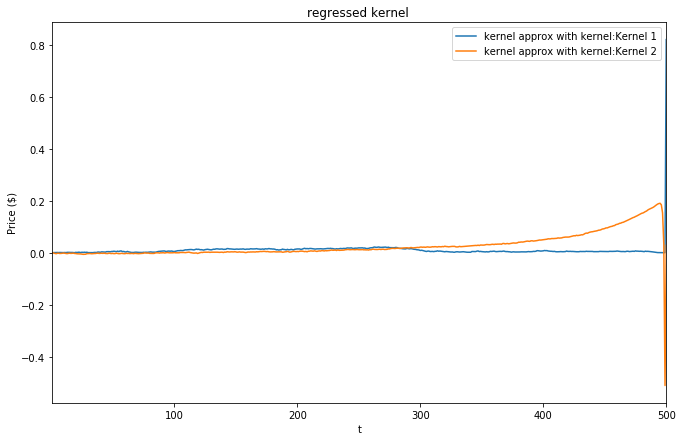

In [22]:
kernels = {'Kernel 1': GNNTBPL_approx1_two_features_SPMINI, 'Kernel 2': GNNTBPL_approx2_two_features_SPMINI}
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_kernels(kernels, ax)

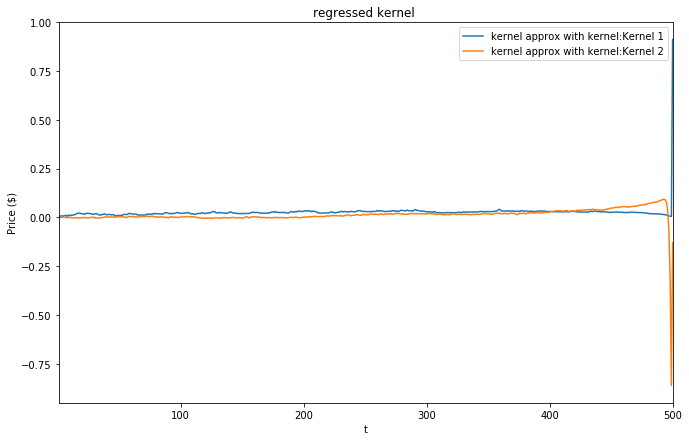

In [23]:
kernels = {'Kernel 1': GNNTBPL_approx1_two_features_UST, 'Kernel 2': GNNTBPL_approx2_two_features_UST}
fig, (ax) = plt.subplots(1, 1, figsize = [11, 7])
plot_kernels(kernels, ax)

In [ ]:
returnsapproxGNNTBPL_SPMINI = model_with_two_baskets_SPMINI.predict(matrix_two_baskets_SPMINI)
returnsapproxGNNTBPL_UST = model_with_two_baskets_UST.predict(matrix_two_baskets_UST)
% store returnsapproxGNNTBPL_SPMINI
% store returnsapproxGNNTBPL_UST

R2_PowerModelGNNTBPL_SPMINI = r2_score(Y_SPMINI, returnsapproxGNNTBPL_SPMINI)
print('R^2 train (returns): %.3f' % R2_PowerModelGNNTBPL_SPMINI )

R2_PowerModelGNNTBPL_UST = r2_score(Y_UST, returnsapproxGNNTBPL_UST)
print('R^2 train (returns): %.3f' % R2_PowerModelGNNTBPL_UST )

% store R2_PowerModelGNNTBPL_SPMINI
% store R2_PowerModelGNNTBPL_UST

In [ ]:
synthetic_variogram_GNNTBPL_approx_SPMINI = inter.variogram2(returnsapproxGNNTBPL_SPMINI.cumsum())
synthetic_variogram_GNNTBPL_approx_UST = inter.variogram2(returnsapproxGNNTBPL_UST.cumsum())
% store synthetic_variogram_GNNTBPL_approx_SPMINI
% store synthetic_variogram_GNNTBPL_approx_UST

plt.plot(synthetic_variogram_GNNTBPL_approx_SPMINI)
plt.plot(synthetic_variogram_GNNTBPL_approx_UST)

$\underline{\text{Learning on the residuals:}}$

In [26]:
residuals_SPMINI = returnsapproxGNNTFPL_SPMINI.reshape(1,-1)[0] - Y_SPMINI
residuals_UST = returnsapproxGNNTFPL_UST.reshape(1,-1)[0] - Y_UST

In [27]:
model_two_features_SPMINI_residuals, history_two_features_SPMINI_residuals = DLI.modelDoublePowerLaw(matrix_concat_SPMINI, 
                                                                   residuals_SPMINI, optimizer_SPMINI, batch_size_SPMINI, 
                                                                   epochs = 200)

model_two_features_UST_residuals, history_two_features_UST_residuals = DLI.modelDoublePowerLaw(matrix_concat_UST, 
                                                                   residuals_UST, optimizer_SPMINI, batch_size_UST, 
                                                                   epochs = 200)

Epoch 1/200
6999/6999 [==============================] - 37s 5ms/step - loss: 89.4177 - val_loss: 60.6086
Epoch 2/200
6999/6999 [==============================] - 32s 5ms/step - loss: 80.5436 - val_loss: 54.3127
Epoch 3/200
6999/6999 [==============================] - 32s 5ms/step - loss: 72.8056 - val_loss: 48.7007
Epoch 4/200
6999/6999 [==============================] - 32s 5ms/step - loss: 65.8076 - val_loss: 43.6641
Epoch 5/200
6999/6999 [==============================] - 32s 5ms/step - loss: 59.5316 - val_loss: 39.1499
Epoch 6/200
6999/6999 [==============================] - 32s 5ms/step - loss: 53.8740 - val_loss: 35.1120
Epoch 7/200
6999/6999 [==============================] - 33s 5ms/step - loss: 48.8598 - val_loss: 31.5706
Epoch 8/200
6999/6999 [==============================] - 53s 8ms/step - loss: 44.5196 - val_loss: 28.4781
Epoch 9/200
6999/6999 [==============================] - 39s 6ms/step - loss: 40.5543 - val_loss: 25.7530
Epoch 10/200
6999/6999 [======================

6999/6999 [==============================] - 46s 7ms/step - loss: 0.9426 - val_loss: 0.7591
Epoch 79/200
6999/6999 [==============================] - 31s 4ms/step - loss: 0.9357 - val_loss: 0.7571
Epoch 80/200
6999/6999 [==============================] - 32s 5ms/step - loss: 0.9312 - val_loss: 0.7527
Epoch 81/200
6999/6999 [==============================] - 30s 4ms/step - loss: 0.9258 - val_loss: 0.7497
Epoch 82/200
6999/6999 [==============================] - 30s 4ms/step - loss: 0.9217 - val_loss: 0.7486
Epoch 83/200
6999/6999 [==============================] - 32s 5ms/step - loss: 0.9184 - val_loss: 0.7470
Epoch 84/200
6999/6999 [==============================] - 30s 4ms/step - loss: 0.9153 - val_loss: 0.7455
Epoch 85/200
6999/6999 [==============================] - 31s 4ms/step - loss: 0.9131 - val_loss: 0.7454
Epoch 86/200
6999/6999 [==============================] - 31s 4ms/step - loss: 0.9109 - val_loss: 0.7434
Epoch 87/200
6999/6999 [==============================] - 31s 4ms/st

6999/6999 [==============================] - 32s 5ms/step - loss: 0.8979 - val_loss: 0.7373
Epoch 156/200
6999/6999 [==============================] - 32s 5ms/step - loss: 0.8979 - val_loss: 0.7374
Epoch 157/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.8979 - val_loss: 0.7374
Epoch 158/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.8979 - val_loss: 0.7373
Epoch 159/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.8979 - val_loss: 0.7374
Epoch 160/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.8979 - val_loss: 0.7374
Epoch 161/200
6999/6999 [==============================] - 38s 5ms/step - loss: 0.8979 - val_loss: 0.7374
Epoch 162/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.8979 - val_loss: 0.7373
Epoch 163/200
6999/6999 [==============================] - 33s 5ms/step - loss: 0.8979 - val_loss: 0.7373
Epoch 164/200
6999/6999 [==============================] - 3

6997/6997 [==============================] - 18s 3ms/step - loss: 24.3330 - val_loss: 16.5239
Epoch 26/200
6997/6997 [==============================] - 18s 3ms/step - loss: 23.7125 - val_loss: 15.9665
Epoch 27/200
6997/6997 [==============================] - 18s 3ms/step - loss: 23.0457 - val_loss: 15.3887
Epoch 28/200
6997/6997 [==============================] - 18s 3ms/step - loss: 22.1961 - val_loss: 14.8009
Epoch 29/200
6997/6997 [==============================] - 18s 3ms/step - loss: 21.4839 - val_loss: 14.3156
Epoch 30/200
6997/6997 [==============================] - 18s 3ms/step - loss: 20.8355 - val_loss: 13.8841
Epoch 31/200
6997/6997 [==============================] - 18s 3ms/step - loss: 20.2656 - val_loss: 13.4074
Epoch 32/200
6997/6997 [==============================] - 22s 3ms/step - loss: 19.8769 - val_loss: 13.1186
Epoch 33/200
6997/6997 [==============================] - 21s 3ms/step - loss: 19.2973 - val_loss: 12.6669
Epoch 34/200
6997/6997 [==========================

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6997/6997 [==============================] - 18s 3ms/step - loss: 1.2206 - val_loss: 1.0665
Epoch 141/200
6997/6997 [==============================] - 18s 3ms/step - loss: 1.1962 - val_loss: 1.0573
Epoch 142/200
6997/6997 [==============================] - 20s 3ms/step - loss: 1.1822 - val_loss: 1.0446
Epoch 143/200
6997/6997 [==============================] - 18s 3ms/step - loss: 1.1621 - val_loss: 1.0315
Epoch 144/200
6997/6997 [==============================] - 18s 3ms/step - loss: 1.1460 - val_loss: 1.0215
Epoch 145/200
6997/6997 [==============================] - 18s 3ms/step - loss: 1.1312 - val_loss: 1.0130
Epoch 146/200
6997/6997 [==============================] - 18s 3ms/step - loss: 1.1157 - val_loss: 1.0028
Epoch 147/200
6997/6997 [==============================] - 18s 3ms/step - loss: 1.1018 - val_loss: 0.9939
Epoch 148/200
6997/6997 [==============================] - 21s 3ms/step - loss: 1.0889 - val_loss: 0.9872
Epoch 149/200
6997/6997 [==============================] - 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



6997/6997 [==============================] - 18s 3ms/step - loss: 0.9142 - val_loss: 0.8862
Epoch 188/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.9128 - val_loss: 0.8851
Epoch 189/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.9119 - val_loss: 0.8843
Epoch 190/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.9104 - val_loss: 0.8836
Epoch 191/200
6997/6997 [==============================] - 19s 3ms/step - loss: 0.9086 - val_loss: 0.8830
Epoch 192/200
6997/6997 [==============================] - 19s 3ms/step - loss: 0.9085 - val_loss: 0.8823
Epoch 193/200
6997/6997 [==============================] - 19s 3ms/step - loss: 0.9072 - val_loss: 0.8815
Epoch 194/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.9061 - val_loss: 0.8808
Epoch 195/200
6997/6997 [==============================] - 18s 3ms/step - loss: 0.9050 - val_loss: 0.8803
Epoch 196/200
6997/6997 [==============================] - 1

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [28]:
GNNDPL_approx1_two_features_SPMINI_residuals = pd.concat((pd.Series([0]), pd.Series(model_two_features_SPMINI_residuals.layers[2].kernel[:L+1].numpy().cumsum())))
GNNDPL_approx2_two_features_SPMINI_residuals = pd.concat((pd.Series([0]), pd.Series(model_two_features_SPMINI_residuals.layers[2].kernel[L+1:].numpy().cumsum())))

GNNDPL_approx1_two_features_UST_residuals = pd.concat((pd.Series([0]), pd.Series(model_two_features_UST_residuals.layers[2].kernel[:L+1].numpy().cumsum())))
GNNDPL_approx2_two_features_UST_residuals = pd.concat((pd.Series([0]), pd.Series(model_two_features_UST_residuals.layers[2].kernel[L+1:].numpy().cumsum())))

%store GNNDPL_approx1_two_features_SPMINI_residuals
%store GNNDPL_approx2_two_features_SPMINI_residuals

%store GNNDPL_approx1_two_features_UST_residuals
%store GNNDPL_approx2_two_features_UST_residuals

alphaGNNDPL_approx1_two_features_SPMINI_residuals = model_two_features_SPMINI_residuals.layers[0].kernel.numpy()[0]
alphaGNNDPL_approx2_two_features_SPMINI_residuals = model_two_features_SPMINI_residuals.layers[0].kernel.numpy()[1]

alphaGNNDPL_approx1_two_features_UST_residuals = model_two_features_UST_residuals.layers[0].kernel.numpy()[0]
alphaGNNDPL_approx2_two_features_UST_residuals = model_two_features_UST_residuals.layers[0].kernel.numpy()[1]

%store alphaGNNDPL_approx1_two_features_SPMINI_residuals
%store alphaGNNDPL_approx1_two_features_SPMINI_residuals

%store alphaGNNDPL_approx1_two_features_UST_residuals
%store alphaGNNDPL_approx2_two_features_UST_residuals

Stored 'GNNDPL_approx1_two_features_SPMINI_residuals' (Series)
Stored 'GNNDPL_approx2_two_features_SPMINI_residuals' (Series)
Stored 'GNNDPL_approx1_two_features_UST_residuals' (Series)
Stored 'GNNDPL_approx2_two_features_UST_residuals' (Series)
Stored 'alphaGNNDPL_approx1_two_features_SPMINI_residuals' (float32)
Stored 'alphaGNNDPL_approx1_two_features_SPMINI_residuals' (float32)
Stored 'alphaGNNDPL_approx1_two_features_UST_residuals' (float32)
Stored 'alphaGNNDPL_approx2_two_features_UST_residuals' (float32)


In [31]:
returnsapproxGNNTFPL_SPMINI_residuals = model_two_features_SPMINI_residuals.predict(matrix_concat_SPMINI)
returnsapproxGNNTFPL_UST_residuals = model_two_features_UST_residuals.predict(matrix_concat_UST)
% store returnsapproxGNNTFPL_SPMINI_residuals
% store returnsapproxGNNTFPL_UST_residuals

R2_PowerModelGNNTFPL_SPMINI_residuals = r2_score(Y_SPMINI, returnsapproxGNNTFPL_SPMINI_residuals)
print('R^2 train (returns): %.3f' % R2_PowerModelGNNTFPL_SPMINI_residuals )

R2_PowerModelGNNTFPL_UST_residuals = r2_score(Y_UST, returnsapproxGNNTFPL_UST_residuals)
print('R^2 train (returns): %.3f' % R2_PowerModelGNNTFPL_UST_residuals )

% store R2_PowerModelGNNTFPL_SPMINI_residuals
% store R2_PowerModelGNNTFPL_UST_residuals

Stored 'returnsapproxGNNTFPL_SPMINI_residuals' (ndarray)
Stored 'returnsapproxGNNTFPL_UST_residuals' (ndarray)
R^2 train (returns): -0.002
R^2 train (returns): -0.011
Stored 'R2_PowerModelGNNTFPL_SPMINI_residuals' (float64)
Stored 'R2_PowerModelGNNTFPL_UST_residuals' (float64)


In [ ]:
synthetic_variogram_GNNTBPL_approx_SPMINI_residuals = inter.variogram2(returnsapproxGNNTBPL_SPMINI_residuals.cumsum())
synthetic_variogram_GNNTBPL_approx_UST_residuals = inter.variogram2(returnsapproxGNNTBPL_UST_residuals.cumsum())
% store synthetic_variogram_GNNTBPL_approx_SPMINI_residuals
% store synthetic_variogram_GNNTBPL_approx_UST_residuals

plt.plot(synthetic_variogram_GNNTBPL_approx_SPMINI_residuals)
plt.plot(synthetic_variogram_GNNTBPL_approx_UST_residuals)